<div class="head0">
    <div class="head0__name">
        Diffusion equation with const drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the 1D Fokker-Planck equation by fast and accurate tensor based method.
    </div>
</div>

In [1]:
import sys
import time

import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver as Solver

from IPython.core.display import HTML
with open( './style.css', 'r' ) as f: st = f.read()
HTML('<style>%s</style>' %st)

<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
</div>

Consider 1D equation with constant drift
$$
    dx = f(x, t) \, dt + S d\beta,
    \quad
    d \beta \, d \beta^{\top} = Q dt,
    \quad
    \frac{\partial \rho}{\partial t} = - div \left[ f(x, t) \rho \right] + D \Delta \rho,
    \quad
    \rho(x, 0) = \rho_0(x),
$$
$$
    x \in \Omega = [-5, 5],
    \quad
    \rho(x, t) |_{\partial \Omega} \approx 0,
    \quad
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]},
    \quad
     D = \frac{1}{2} S Q S^{\top} = 1,
$$
with 
$$
    f(x, t) = v = 3 = const.
$$

This equation has exact solution ([see this paper](http://www.icmp.lviv.ua/journal/zbirnyk.73/13002/art13002.pdf); note that there is a typo in the paper for this formula: $\pi$ is missed!)
$$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{4 \pi D t}}
        \exp{\left[
            - \frac
                {
                    \left( x - x_0 - v t \right)^2
                }
                {
                    4 D t
                }
        \right]},
$$
where $x_0$ is an initial condition. We can rewrite this equation in terms of the initial PDF $\rho_0(x)$ as
$$
    \rho(x, t) = \int_{-\infty}^{\infty}
        \rho(x, t, x_0) \rho_0(x_0) \, d x_0,
$$
which after accurate computations leads to analytic solution
$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi s + 4 \pi D t}
            }
        \exp{ \left[
            - \frac
                {
                    (x - vt)^2
                }
                {
                    2  s + 4 D t
                }
        \right] },
$$
with the zero stationary ($t \rightarrow \infty$) solution.

In [2]:
v = 3.
s = 0.1

def func_f0(x, t):
    return v * np.ones(x.shape)

def func_f1(x, t):
    return np.zeros(x.shape)

def func_r0(x):
    r = np.exp(-0.5 * x**2 / s) / np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rt(x, t):
    Dc = 1.
    r = np.exp(-1. * (x - v * t)**2 / (2. * s + 4. * Dc * t))
    r/= np.sqrt(2. * np.pi * s + 4. * np.pi * Dc * t)
    return r.reshape(-1)

def func_rs(x):
    r = np.zeros(x.shape)
    return r.reshape(-1)

def show_x(X, r_calc, _time):
    X = X.reshape(1, -1)
    r_real = func_rt(X.reshape(1, -1), t_max)
    e = np.linalg.norm(r_real - r_calc) / np.linalg.norm(r_real)

    plt.plot(
        X.reshape(-1), r_calc, label='Calculated',
        linewidth=1, color='tab:green', marker='o', markersize=7,
        markerfacecolor='lightgreen', markeredgecolor='g'
    )
    plt.plot(
        X.reshape(-1), r_real, label='Analytic',
        linewidth=3, color='black'
    )
    plt.title('Solution at final time step')
    plt.xlabel('x')
    plt.ylabel('r')
    plt.legend(loc='best')
    plt.show()

    print('Number of spatial points : %8d'%x_poi)
    print('Number of time points    : %8d'%t_poi)
    print('Error (relative norm)    : %-12.2e'%e)
    print('Total time (sec)         : %-12.2e'%_time)

In [3]:
t_poi = 1000
t_min = 0.
t_max = 1.

x_poi = 121
x_min = -10.
x_max = +10.

m = t_poi
n = x_poi
l = (x_max - x_min) / x_poi
h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

print('Time-space factor (h/l^2) : %-8.5f'%(h/l/l))

Time-space factor (h/l^2) : 0.03664 


<div class="head1">
    <div class="head1__name">
        Explicit solution 1
    </div>
    <div class="head1__note">
        Euler solver and uniform spatial grid (only for example)
    </div>
</div>

We can solve this 1D equation on the uniform spatial grid for the time $t > 0$ with step $h$ and uniform spatial grid with step $l$ using 2th order finite difference scheme

$$
    \frac{\partial \rho}{\partial t} = (D + Q) \rho,
$$
where
$$
    D = \frac{1}{l^2} tridiag \left( 1, -2, 1 \right),
    \quad
    Q = \frac{1}{2 l} tridiag \left( -1, 0, 1 \right).
$$

Let apply 1th order splitting method on the time step $(k+1)$
$$
    \frac{\partial v}{\partial t} = D v,
    \quad
    v_{k} = \rho_{k},
    \quad
    v_{k+1} = v = ?,
$$
$$
    \frac{\partial w}{\partial t} = Q w,
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = \rho_{k+1} = ?,
$$
and solve both ODE by 1th order Euler method.

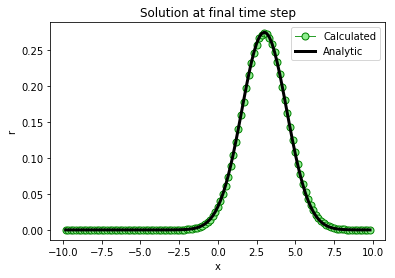

Number of spatial points :      121
Number of time points    :     1000
Error (relative norm)    : 9.29e-03    
Total time (sec)         : 1.12e-01    


In [4]:
_time = time.time()

X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)[:, 1:-1]
Q = sp.spdiags([ [-1.]*n, [1.]*n ], [-1,  1], n, n).tocsr() 
Q = -v * Q
Q = (Q / 2 / l).toarray()[1:-1, 1:-1]
D = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() 
D = (D / l / l).toarray()[1:-1, 1:-1]

r = func_r0(X)
for t in T[1:]:
    w0 = r
    w1 = w0 + h * D @ w0
    v0 = w1
    v1 = v0 + h * Q @ v0
    r = v1

show_x(X, r, time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Explicit solution 2
    </div>
    <div class="head1__note">
        Runge-Kutta solver and uniform spatial grid (only for example)
    </div>
</div>

We can solve this 1D equation as in the previous case but using 4th order Runge–Kutta method by standard scipy solver and 2th order splitting method.

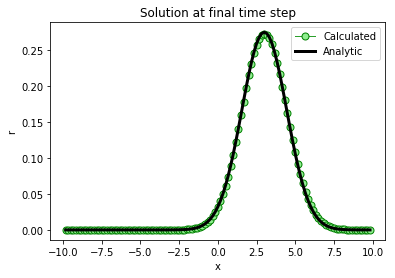

Number of spatial points :      121
Number of time points    :     1000
Error (relative norm)    : 1.01e-02    
Total time (sec)         : 1.37e+00    


In [5]:
_time = time.time()

X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)[:, 1:-1]
Q = sp.spdiags([ [-1.]*n, [1.]*n ], [-1,  1], n, n).tocsr() 
Q = (Q / 2 / l).toarray()[1:-1, 1:-1]
D = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() 
D = (D / l / l).toarray()[1:-1, 1:-1]

def func_d(t, r):
    return D @ r

def func_q(t, r):
    return -1. * v * Q @ r

r = func_r0(X)
for t in T[1:]:
    w0 = r
    w1 = solve_ivp(func_d, [t - h/2, t], w0).y[:, -1]
    v0 = w1
    v1 = solve_ivp(func_q, [t - h, t], v0).y[:, -1]
    w2 = v1
    w3 = solve_ivp(func_d, [t - h/2, t], w2).y[:, -1]
    r = w3
    
show_x(X, r, time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Explicit solution by matrix exp.
    </div>
    <div class="head1__note">
        We can use the same approach but apply matrix exponent instead of the Runge–Kutta method.
    </div>
</div>

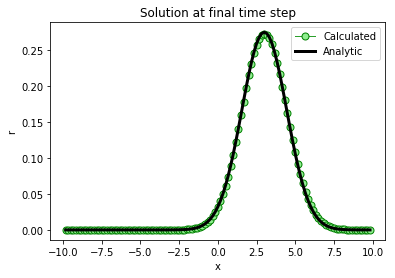

Number of spatial points :      121
Number of time points    :     1000
Error (relative norm)    : 1.01e-02    
Total time (sec)         : 3.89e-02    


In [6]:
_time = time.time()

X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)[:, 1:-1]
Q = sp.spdiags([ [-1.]*n, [1.]*n ], [-1,  1], n, n).tocsr() 
Q = (Q / 2 / l).toarray()[1:-1, 1:-1]
Q = -v * Q
ZQ = expm(h * Q)
D = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() 
D = (D / l / l).toarray()[1:-1, 1:-1]
ZD = expm(h * D)
    
r = func_r0(X)
for t in T[1:]:
    w0 = r
    w1 = ZD @ w0
    v0 = w1
    v1 = ZQ @ v0
    r = v1

show_x(X, r, time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Solution by the solver
    </div>
</div>

In [7]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(t_poi, t_min, t_max)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.prep()
SL.calc()

Solve: 100%|███████| 999/999 [00:17<00:00, 58.28step/s, Norm 8.86e-01]


In [8]:
SL.info()

---------- Solver
Format   : 1D, NP
Grid x   : poi =       121, min =  -10.0000, max =   10.0000
Grid t   : poi =      1000, min =    0.0000, max =    1.0000
Time sec : prep = 1.10e-02, calc = 1.40e+01


<div class="head2">
    <div class="head2__name">
        Solution near boundaries
    </div>
    <div class="head2__note">
        Analytic solution is not vanish on the boundaries at selected time interval (but stationary solution will be zero), so we could not expect very good accuracy of our solver.
    </div>
</div>

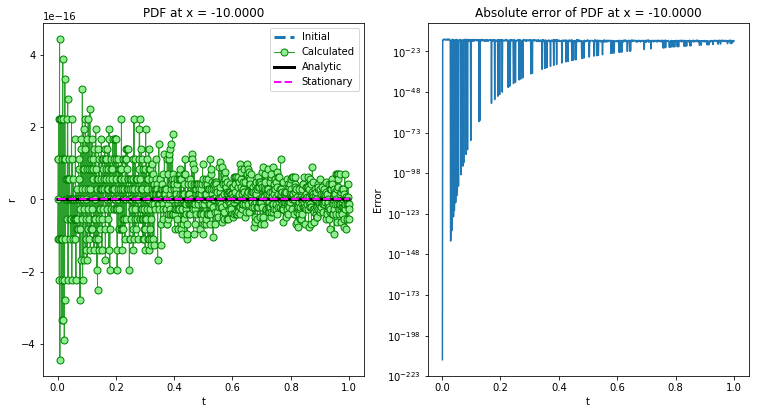

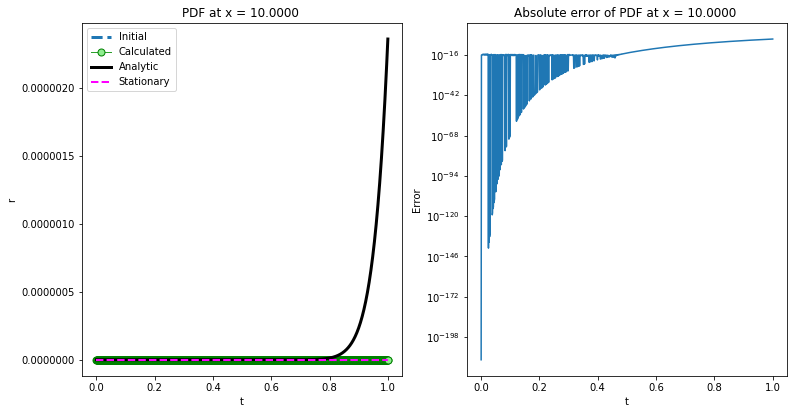

In [9]:
SL.plot_t(x=-10.0, is_err_abs=True)
SL.plot_t(x=+10.0, is_err_abs=True)

<div class="head2">
    <div class="head2__name">
        Solution in the inner points
    </div>
    <div class="head2__note">
        Solution is very accurate.
    </div>
</div>

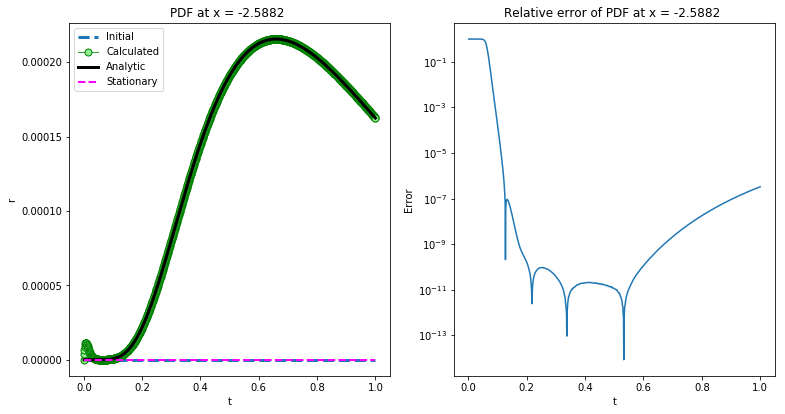

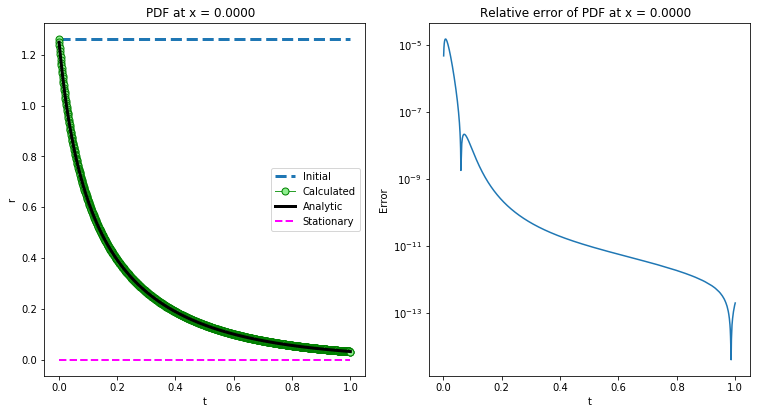

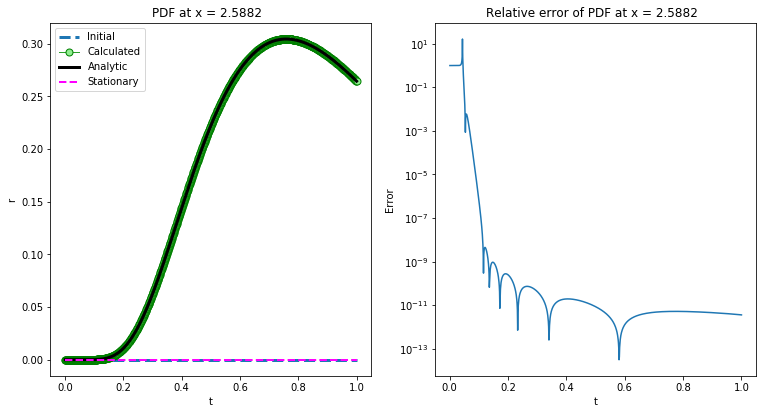

In [10]:
SL.plot_t(x=-2.5)
SL.plot_t(x=+0.0)
SL.plot_t(x=+2.5)

<div class="head2">
    <div class="head2__name">
        Solution for different time steps
    </div>
    <div class="head2__note">
        Solution is not accurate at the final time step since analytic solution is not vanish on the boundaries.
    </div>
</div>

./../lib/solver.py:396: RuntimeWarning: divide by zero encountered in true_divide
  e/= np.abs(R1)


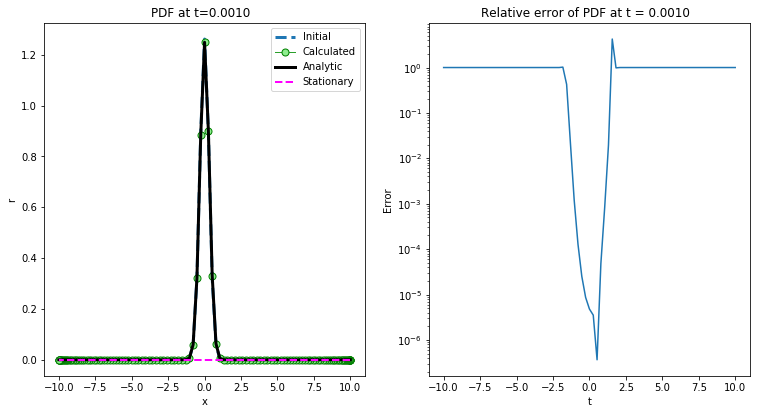

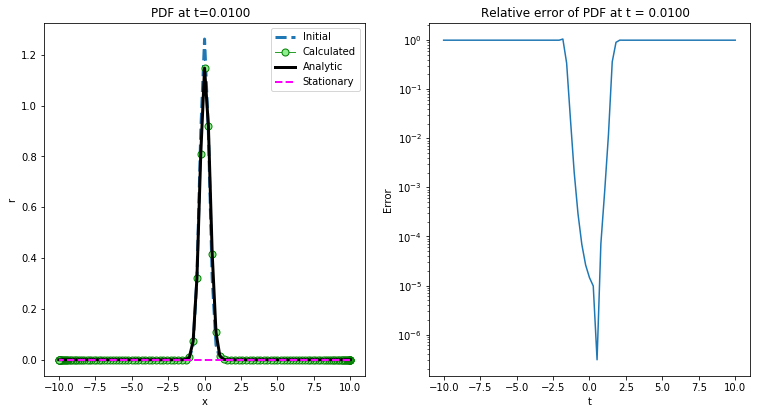

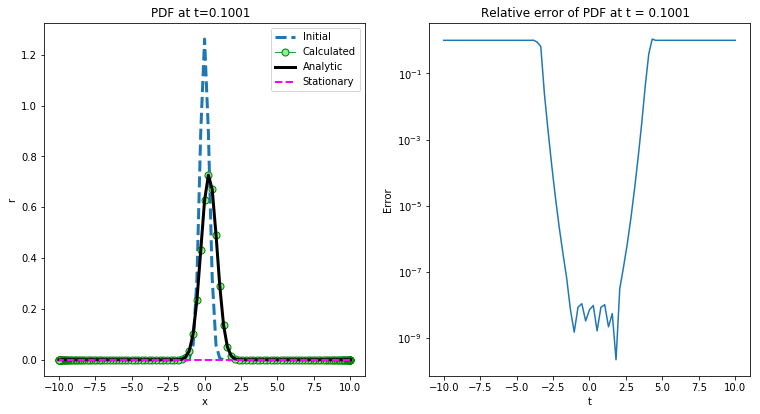

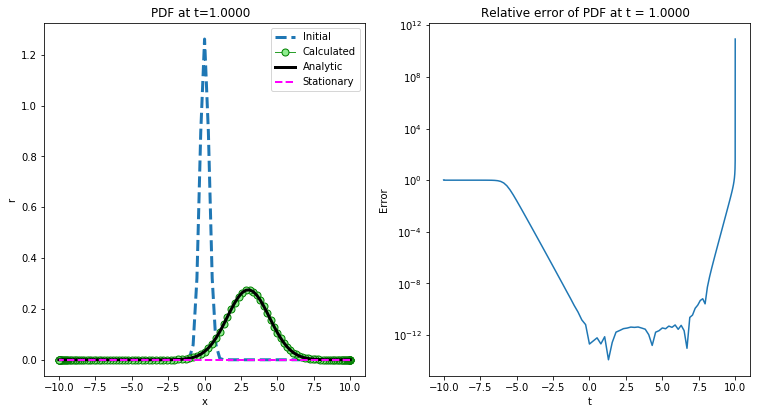

In [11]:
SL.plot_x(t=0.001)
SL.plot_x(t=0.01)
SL.plot_x(t=0.1)
SL.plot_x()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of spatial points
    </div>
    <div class="head1__note">
        Note that analytic solution is small but not zero at boundaries, hence the integral (norm) error is not small for any grid size.
    </div>
</div>

In [12]:
m = 1000
N = [10, 50, 100, 200]
Times = []
Errors = []

for n in N:
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(m, t_min, t_max)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    
    Times.append([SL._t_prep, SL._t_calc])
    Errors.append(e)

Solve: 100%|███████| 999/999 [00:20<00:00, 49.79step/s, Norm 1.14e+00]


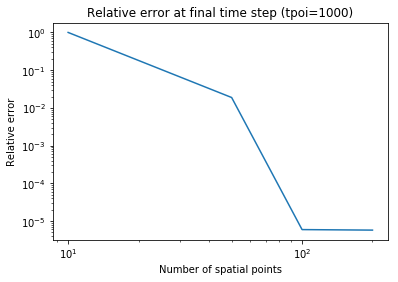



Solver info for n = 200, m = 1000 : 
---------- Solver
Format   : 1D, NP
Grid x   : poi =       200, min =  -10.0000, max =   10.0000
Grid t   : poi =      1000, min =    0.0000, max =    1.0000
Time sec : prep = 4.53e-02, calc = 1.79e+01


In [13]:
plt.plot(N, Errors)
plt.semilogx()
plt.semilogy()
plt.title('Relative error at final time step (tpoi=%d)'%m)
plt.xlabel('Number of spatial points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d, m = %d : '%(N[-1], m))
SL.info()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of time points
    </div>
    <div class="head1__note">
        Note that analytic solution is small but not zero at boundaries, hence the integral (norm) error is not small for any grid size.
    </div>
</div>

In [22]:
n = 100
M = [10, 100, 1000, 5000, 10000]
Times = []
Errors = []

for m in M:
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(m, t_min, t_max)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    
    Times.append([SL._t_prep, SL._t_calc])
    Errors.append(e)

Solve: 100%|█████| 9999/9999 [02:33<00:00, 65.04step/s, Norm 8.05e-01]


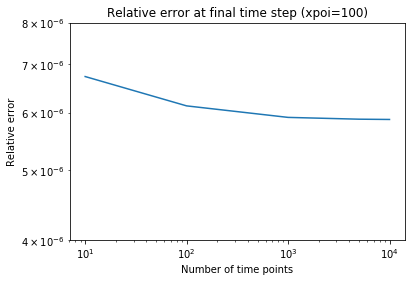



Solver info for n = 10000, m = 100 : 
---------- Solver
Format   : 1D, NP
Grid x   : poi =       100, min =  -10.0000, max =   10.0000
Grid t   : poi =     10000, min =    0.0000, max =    1.0000
Time sec : prep = 7.30e-03, calc = 1.20e+02


In [26]:
plt.plot(M, Errors)
plt.semilogx()
plt.semilogy()
plt.ylim(4.E-6, 8.E-6)
plt.title('Relative error at final time step (xpoi=%d)'%n)
plt.xlabel('Number of time points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d, m = %d : '%(M[-1], n))
SL.info()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of spatial and time points
    </div>
    <div class="head1__note">
        Note that analytic solution is small but not zero at boundaries, hence the integral (norm) error is not small for any grid size.
    </div>
</div>

Let set constant factor $p=\frac{h}{l^2}$ and calculate solution for different spatial steps $l$ (and the corresponding time steps $h = p l^2$).

In [17]:
p = 0.1
N = [10, 50, 100, 200]
M = []
Times = []
Errors = []

for n in N:
    l = (x_max - x_min) / n
    h = p * l * l
    m = int((t_max - t_min) / h) + 1
    M.append(m)
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(m, t_min, t_max)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    
    Times.append([SL._t_prep, SL._t_calc])
    Errors.append(e)

Solve: 100%|███████| 999/999 [00:19<00:00, 50.37step/s, Norm 1.14e+00]


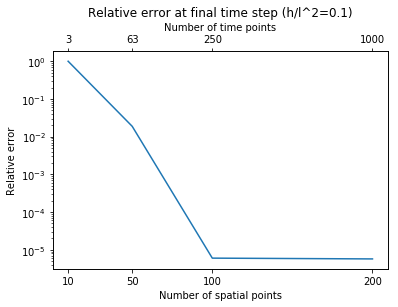

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(N, Errors)
ax1.semilogy()
ax1.set_xticks(N)
ax1.set_title('Relative error at final time step (h/l^2=%-2.1f)'%p)
ax1.set_xlabel('Number of spatial points')
ax1.set_ylabel('Relative error')
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(N)
ax2.set_xticklabels(["%d"%m for m in M])
ax2.set_xlabel('Number of time points')
plt.show()

In [20]:
p = 0.9
N = [20, 50, 100, 200]
M = []
Times = []
Errors = []

for n in N:
    l = (x_max - x_min) / n
    h = p * l * l
    m = int((t_max - t_min) / h) + 1
    M.append(m)
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(m, t_min, t_max)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    
    Times.append([SL._t_prep, SL._t_calc])
    Errors.append(e)

Solve: 100%|███████| 111/111 [00:02<00:00, 44.81step/s, Norm 1.14e+00]


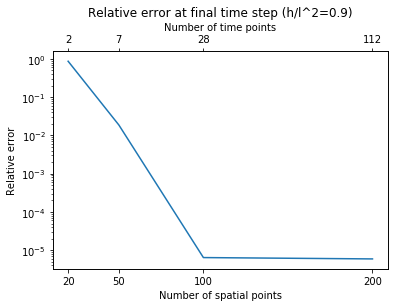

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(N, Errors)
ax1.semilogy()
ax1.set_xticks(N)
ax1.set_title('Relative error at final time step (h/l^2=%-2.1f)'%p)
ax1.set_xlabel('Number of spatial points')
ax1.set_ylabel('Relative error')
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(N)
ax2.set_xticklabels(["%d"%m for m in M])
ax2.set_xlabel('Number of time points')
plt.show()

<div class="end"></div>